In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)


In [ ]:
#!pip install -U scikit-learn


In [2]:
from sklearn.metrics import mean_absolute_percentage_error


In [3]:
df = pd.read_csv("train.csv")
df.columns = ["tarih","enerji"]
df.head()

,tarih,enerji
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701


In [4]:
df["logenerji"] = np.log(df["enerji"])

In [5]:
Ntest = 744
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [6]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [7]:
df['difflogenerji'] = df['logenerji'].diff()

In [ ]:
df

,tarih,enerji,logenerji,difflogenerji
0,2018-01-01 00:00:00,1593.944216,7.373967,NaN
1,2018-01-01 01:00:00,1513.933887,7.322467,-0.051500
2,2018-01-01 02:00:00,1402.612637,7.246092,-0.076375
3,2018-01-01 03:00:00,1278.527266,7.153464,-0.092628
4,2018-01-01 04:00:00,1220.697701,7.107178,-0.046286
...,...,...,...,...
40147,2022-07-31 19:00:00,2492.489498,7.821037,-0.009623
40148,2022-07-31 20:00:00,2479.958245,7.815997,-0.005040
40149,2022-07-31 21:00:00,2485.016884,7.818035,0.002038
40150,2022-07-31 22:00:00,2396.574255,7.781796,-0.036239


In [8]:
# Make supervised dataset
series = df['difflogenerji'].dropna().to_numpy()

T = 16
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (40135, 16, 1) Y.shape (40135,)


In [9]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [10]:
# RNN
i = Input(shape=(T, 1))
x = LSTM(24)(i)
x = Dense(1)(x)
model = Model(i, x)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [13]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=100,
  validation_data=(Xtest, Ytest)
)

Epoch 1/100
1231/1231 [==============================] - 14s 6ms/step - loss: 0.0015 - val_loss: 7.6241e-04
Epoch 2/100
1231/1231 [==============================] - 6s 5ms/step - loss: 9.9688e-04 - val_loss: 6.4157e-04
Epoch 3/100
1231/1231 [==============================] - 6s 4ms/step - loss: 9.1993e-04 - val_loss: 5.6354e-04
Epoch 4/100
1231/1231 [==============================] - 5s 4ms/step - loss: 8.7683e-04 - val_loss: 5.2039e-04
Epoch 5/100
1231/1231 [==============================] - 5s 4ms/step - loss: 8.2504e-04 - val_loss: 4.5371e-04
Epoch 6/100
1231/1231 [==============================] - 5s 4ms/step - loss: 7.8557e-04 - val_loss: 4.8551e-04
Epoch 7/100
1231/1231 [==============================] - 5s 4ms/step - loss: 7.4548e-04 - val_loss: 4.9919e-04
Epoch 8/100
1231/1231 [==============================] - 6s 5ms/step - loss: 7.0835e-04 - val_loss: 4.0292e-04
Epoch 9/100
1231/1231 [==============================] - 5s 4ms/step - loss: 6.9142e-04 - val_loss: 3.6189e-04
Epoc

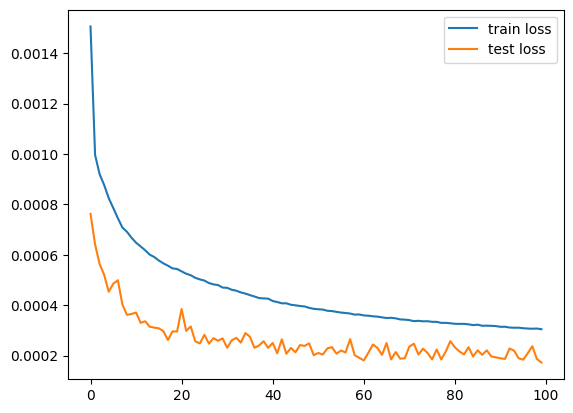

In [14]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [15]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [16]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()
Ptest

24/24 [==============================] - 0s 2ms/step


array([-7.82277063e-02, -7.79587105e-02, -5.95562384e-02, -3.68440486e-02,
       -2.93834861e-02, -1.40316989e-02, -1.06777679e-02,  7.12320954e-02,
        1.72670692e-01,  1.27042383e-01,  6.09696433e-02,  4.68700156e-02,
       -1.36021096e-02,  3.50558013e-02,  2.22640317e-02, -3.48220230e-03,
       -2.22970755e-03, -2.45255698e-02, -5.61735183e-02, -4.15951014e-02,
       -8.28666147e-03, -5.80112869e-03, -4.44636308e-02, -5.78552261e-02,
       -7.53435269e-02, -7.79961869e-02, -6.09318316e-02, -4.11186889e-02,
       -3.05659976e-02, -1.24820080e-02, -2.22938191e-02,  7.67435357e-02,
        1.64844051e-01,  1.18848257e-01,  7.27080405e-02,  4.87851053e-02,
        9.09822993e-03,  2.73845922e-02,  1.23915505e-02, -7.70370523e-03,
       -6.47872919e-03, -1.73815954e-02, -2.06133928e-02, -2.05006748e-02,
       -2.64857174e-03,  1.36727060e-03, -4.51576076e-02, -5.82524613e-02,
       -7.44297951e-02, -7.91482180e-02, -6.22120574e-02, -3.46379764e-02,
       -3.03814244e-02, -

In [17]:
# Needed to compute un-differenced predictions
df['shiftlogenerji'] = df['logenerji'].shift(1)
prev = df['shiftlogenerji']

In [18]:
# Last-known train value
last_train = train.iloc[-1]['logenerji']

In [19]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

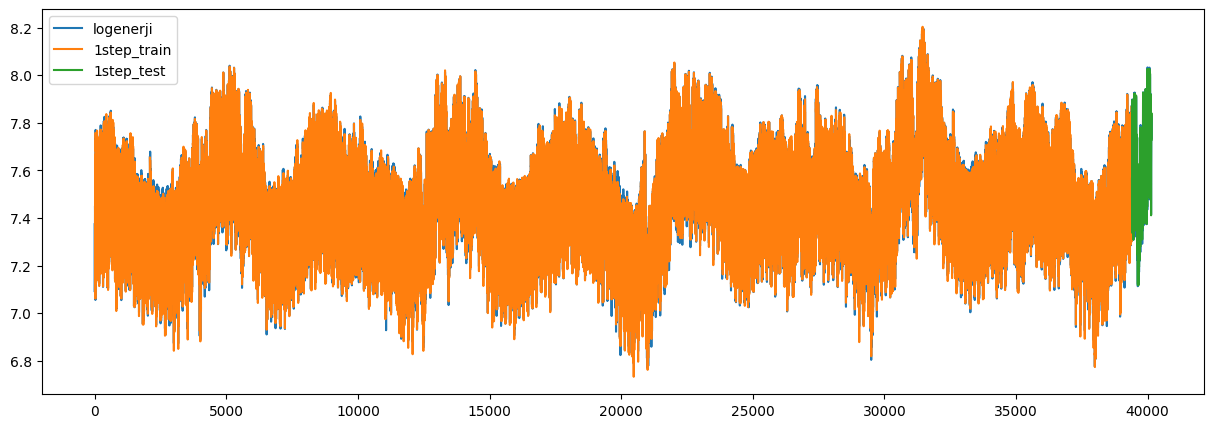

In [25]:
# plot 1-step forecast
df[['logenerji', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [21]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, 1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 17ms/step


In [22]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

(38000.0, 41000.0)

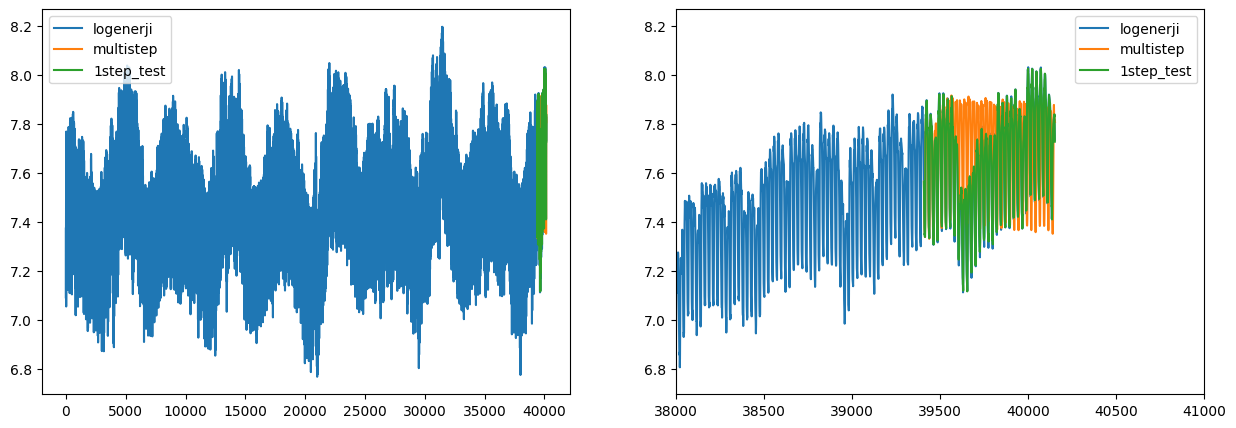

In [32]:
# plot 1-step and multi-step forecast
fig, ax = plt.subplots(1, 2, figsize = (30,10))
df[['logenerji', 'multistep', '1step_test']].plot(figsize=(15, 5),ax=ax[0]);
df[['logenerji', 'multistep', '1step_test']].plot(figsize=(15, 5),ax=ax[1]);
ax[1].set_xlim(38000,41000)


In [33]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['logenerji']
mape1 = mean_absolute_percentage_error(
    np.exp(test_log_pass), np.exp(df.loc[test_idx, 'multistep']))
print("multi-step MAPE:", mape1)


multi-step MAPE: 0.16393028622166747


In [34]:
# make multi-output supervised dataset
Tx = 12
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (39396, 12, 1) Y.shape (39396, 744)


In [35]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [36]:
# RNN
i = Input(shape=(Tx, 1))
x = LSTM(24, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [38]:
check_point = ModelCheckpoint(
    'best_model_multi_output.h5', monitor='val_loss', save_best_only=True)

In [39]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [40]:

r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=450,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/450
1232/1232 [==============================] - 8s 4ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 2/450
1232/1232 [==============================] - 5s 4ms/step - loss: 0.0012 - val_loss: 8.9129e-04
Epoch 3/450
1232/1232 [==============================] - 5s 4ms/step - loss: 0.0011 - val_loss: 7.1024e-04
Epoch 4/450
1232/1232 [==============================] - 5s 4ms/step - loss: 9.9960e-04 - val_loss: 5.8296e-04
Epoch 5/450
1232/1232 [==============================] - 6s 5ms/step - loss: 9.6895e-04 - val_loss: 5.2814e-04
Epoch 6/450
1232/1232 [==============================] - 5s 4ms/step - loss: 9.4882e-04 - val_loss: 4.4563e-04
Epoch 7/450
1232/1232 [==============================] - 6s 5ms/step - loss: 9.3563e-04 - val_loss: 5.4846e-04
Epoch 8/450
1232/1232 [==============================] - 5s 4ms/step - loss: 9.2389e-04 - val_loss: 5.5164e-04
Epoch 9/450
1232/1232 [==============================] - 6s 5ms/step - loss: 9.1395e-04 - val_loss: 4.5254e-04
Epoch 10/450
1232

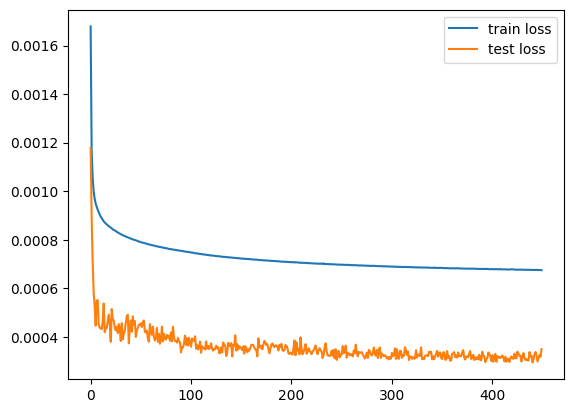

In [41]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [43]:
# load best model
best_model = tf.keras.models.load_model('best_model_multi_output.h5')

In [44]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 23ms/step


In [45]:
Ptrain.shape, Ptest.shape

((39395, 744), (1, 744))

In [46]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [47]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

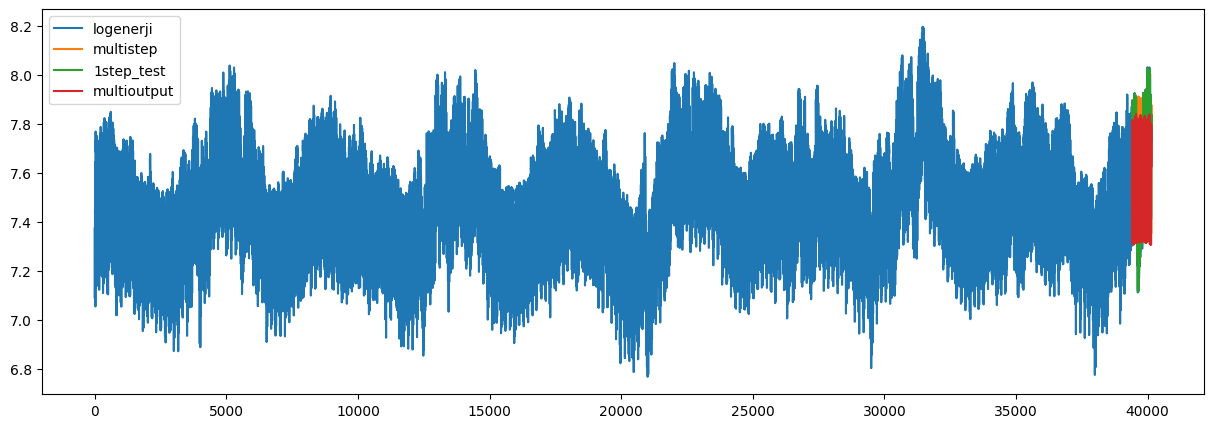

In [48]:
# plot all forecasts
cols = ['logenerji', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [50]:
# RNN multiple LSTM layers
i = Input(shape=(Tx, 1))
x = LSTM(16, return_sequences=True)(i)
x = LSTM(16, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [51]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True)

In [52]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [53]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=100,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/100
1232/1232 [==============================] - 12s 6ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 2/100
1232/1232 [==============================] - 8s 6ms/step - loss: 0.0012 - val_loss: 7.7814e-04
Epoch 3/100
1232/1232 [==============================] - 7s 5ms/step - loss: 0.0011 - val_loss: 7.2968e-04
Epoch 4/100
1232/1232 [==============================] - 7s 6ms/step - loss: 0.0010 - val_loss: 6.6893e-04
Epoch 5/100
1232/1232 [==============================] - 7s 6ms/step - loss: 9.8602e-04 - val_loss: 5.4107e-04
Epoch 6/100
1232/1232 [==============================] - 7s 5ms/step - loss: 9.6348e-04 - val_loss: 4.8485e-04
Epoch 7/100
1232/1232 [==============================] - 7s 6ms/step - loss: 9.4774e-04 - val_loss: 5.7790e-04
Epoch 8/100
1232/1232 [==============================] - 7s 5ms/step - loss: 9.3321e-04 - val_loss: 6.1351e-04
Epoch 9/100
1232/1232 [==============================] - 8s 6ms/step - loss: 9.2314e-04 - val_loss: 5.3181e-04
Epoch 10/100
1232/12

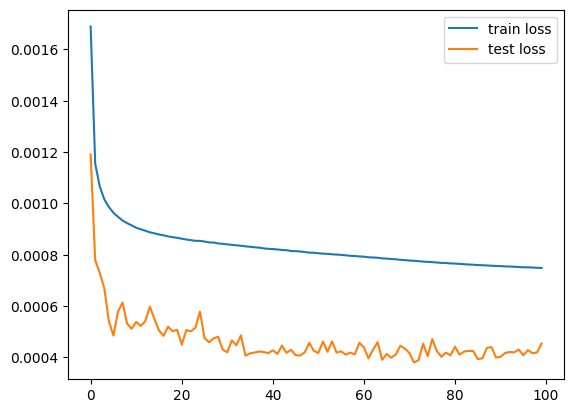

In [54]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [55]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [56]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

1/1 [==============================] - 0s 19ms/step


In [57]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput2'] = last_train + \
  np.cumsum(Ptest)

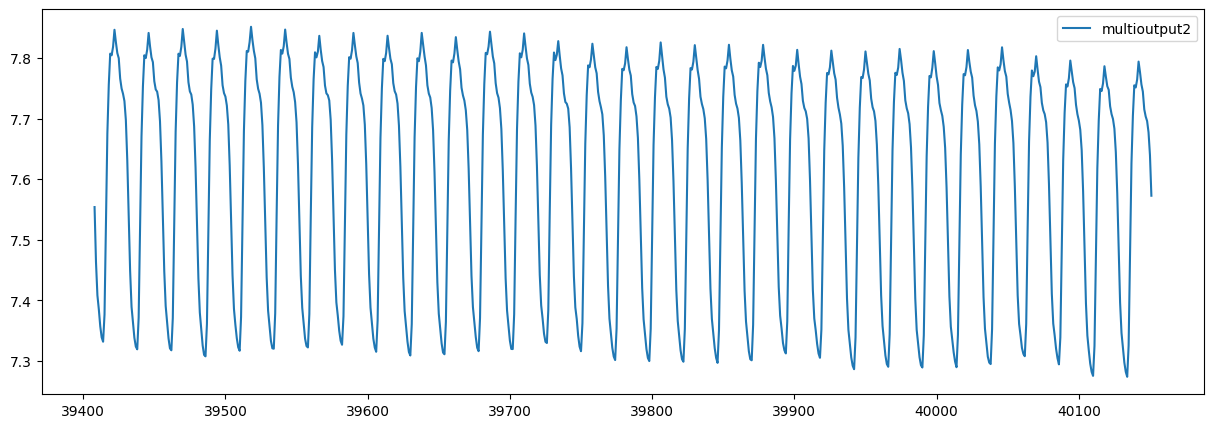

In [58]:
# plot all forecasts
cols = ['multioutput2']
df[cols].plot(figsize=(15, 5));

In [59]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['logenerji']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput2'])
print("multi-output (2 LSTMs) MAPE:", mape3)

multi-step MAPE: 0.02074818611911319
multi-output MAPE: 0.013070687776103925
multi-output (2 LSTMs) MAPE: 0.014957579058239856
